## Comparison between theory and simulations for dropout regularization

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
from tqdm import tqdm
from scipy.special import erf as nerf

## Auxiliary functions for the numerical simulations

In [65]:
def generate_data(num_samples,sigma,ws,vs):
    _,N=ws.shape
    X=normal(0,1.,size=(num_samples,N)) 
    zeta=normal(0,1.,size=num_samples) 
    Y=nerf(X@ws.T/np.sqrt(N)/np.sqrt(2))@vs + sigma*zeta
    
    return X,Y

In [66]:
def compute_gradient(w,v,x,y,eta_w,eta_v):
    K,N=w.shape
    lam=x@w.T/np.sqrt(N)
    yhat=nerf(lam/np.sqrt(2))@v
    Delta=yhat-y
    dw=-eta_w*Delta*np.outer(v*np.exp(-lam**2/2),x)/np.sqrt(N)*np.sqrt(2/np.pi)
    dv=-eta_v*Delta*nerf(lam/np.sqrt(2))/N
    return dw,dv.reshape(K,)

In [67]:
def compute_mse_sim(w,v,Xtest,Ytest):
    K,N=w.shape
    lam=Xtest@w.T/np.sqrt(N)
    Yhat=nerf(lam/np.sqrt(2))@v
    return np.mean((Yhat-Ytest)**2/2)

In [68]:
def run_simulations(w0,v0,ws,vs,eta_w,eta_v,sigma,dropout_rates,num_steps,samples_test=100,downsampling=1):
    K,N=w0.shape
    M,_=ws.shape
    W=np.zeros(K)
    V=np.zeros(K)

    output_length=num_steps//downsampling
    
    Rsim=np.zeros((output_length,K,M))
    Qsim=np.zeros((output_length,K,K))
    errors=np.zeros(output_length)

    W=w0.copy()
    V=v0.copy()
    
    Xtest,Ytest=generate_data(samples_test,0,ws,vs)
    
    for t in tqdm(range(num_steps)):

        X,Y=generate_data(1,sigma,ws,vs)
        
        ptmp=dropout_rates[t]
        active_nodes = np.random.choice([0, 1], size=K, p=[1-ptmp, ptmp])

        dw,dv=compute_gradient(W,V*active_nodes,X[0],Y[0],eta_w,eta_v*active_nodes)

        W=W+dw
        V=V+dv

        if t%downsampling==0:
            
            Qsim[t//downsampling]=W@W.T/N
            Rsim[t//downsampling]=W@ws.T/N
            errors[t//downsampling]=compute_mse_sim(W,V*ptmp,Xtest,Ytest)

    return W,V,Qsim,Rsim,errors    

## Auxiliary functions for the theory

In [69]:
import casadi
from casadi import *

In [70]:
def J2(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    return (2/pi)/sqrt(1+c11+c22+c11*c22-c12**2)

def I2(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    return asin(c12/(sqrt(1+c11)*sqrt(1+c22)))/pi


def I3(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    c13=C[0][2]
    c23=C[1][2]
    c33=C[2][2]

    Lambda3=(1+c11)*(1+c33)-c13**2

    return (2/pi)*(1/sqrt(Lambda3))*(c23*(1+c11)-c12*c13)/(1+c11)

def I4(C):
    c12=C[0][1]
    c11=C[0][0]
    c22=C[1][1]
    c13=C[0][2]
    c23=C[1][2]
    c33=C[2][2]
    c14=C[0][3]
    c24=C[1][3]
    c34=C[2][3]
    c44=C[3][3]

    Lambda4=(1+c11)*(1+c22)-c12**2

    Lambda0=Lambda4*c34-c23*c24*(1+c11)-c13*c14*(1+c22)+c12*c13*c24+c12*c14*c23
    Lambda1=Lambda4*(1+c33)-c23**2*(1+c11)-c13**2*(1+c22)+2*c12*c13*c23
    Lambda2=Lambda4*(1+c44)-c24**2*(1+c11)-c14**2*(1+c22)+2*c12*c14*c24

    return (4/pi**2)*(1/sqrt(Lambda4))*asin(Lambda0/sqrt(Lambda1*Lambda2))
    
def compute_mse(Q,R,T,v,vs,p):
    K,M=R.size()[0],R.size()[1]
    ret=MX(0)
    for i in range(K):
        for j in range(K):
            ret+=(p**2)*v[i]*v[j]*I2([[Q[i,i],Q[i,j]],[Q[j,i],Q[j,j]]])


    for n in range(M):
        for m in range(M):
            ret+=vs[n]*vs[m]*I2([[T[n,n],T[n,m]],[T[m,n],T[m,m]]])

    for i in range(K):
        for n in range(M):
            ret-=2*v[i]*vs[n]*p*I2([[Q[i,i],R[i,n]],[R[i,n],T[n,n]]])
    return ret
    

In [71]:
K=2 #number of student hidden nodes
M=1 #number of teacher hidden nodes
Q = MX.sym('Q', K, K)  #st-st overlap
R = MX.sym('R', K, M)  #st-th overlap
T = MX.sym('T', M, M)  #th-th overlap
v = MX.sym('v', K)  #student readout weights
vs = MX.sym('vs', M) #teacher readout weights
p= MX.sym('p', 1) #activation probability
eta= MX.sym('eta', 1) #learning rate
sigma=MX.sym('sigma', 1) #standard deviation of the label noise
mse_sym = compute_mse(Q,R,T,v,vs,p)
mse_func = Function('mse_func', [Q,R,T,v,vs,p], [mse_sym])

In [72]:
#initial conditions
np.random.seed(1974)
N=30000
downsampling=5000
ws=normal(0,1.,size=(M,N))
w0=normal(0,1,size=(K,N))
w0=0*w0
Q0=w0@w0.T/N
R0=w0@ws.T/N
T=ws@ws.T/N
v0=np.ones(K)
vs=np.ones(M)

In [74]:
alphaF = 5 
N_control = 100 # number of control intervals
L=MX(0)

In [75]:
O = MX.sym('O',K*K+K*M+K)
Q, R, v = O[:K*K], O[K*K:K*K+K*M],O[K*K+K*M:]
Q = reshape(Q, K, K)
R = reshape(R, K, M)
U = MX.sym('U',3)
r,eta,sigma=U[0],U[1],U[2]

In [76]:
#theoretical ODEs
dQ=MX.zeros(K,K)
dR=MX.zeros(K,M)
dv=MX.zeros(K)

for i in range(K):
    for n in range(M):
        for m in range(M):
            dR[i,n]+=eta*r*v[i]*vs[m]*I3([[Q[i,i],R[i,n],R[i,m]],[R[i,n],T[n,n],T[n,m]],[R[i,m],T[m,n],T[m,m]]])
        for j in range(K):
            if j!=i:
                dR[i,n]-=eta*r*r*v[i]*v[j]*I3([[Q[i,i],R[i,n],Q[i,j]],[R[i,n],T[n,n],R[j,n]],[Q[i,j],R[j,n],Q[j,j]]])
            else:
                dR[i,n]-=eta*r*v[i]*v[j]*I3([[Q[i,i],R[i,n],Q[i,j]],[R[i,n],T[n,n],R[j,n]],[Q[i,j],R[j,n],Q[j,j]]])
                                    
for i in range(K):
    for k in range(K):
        for m in range(M):
            dQ[i,k]+=eta*r*v[i]*vs[m]*I3([[Q[i,i],Q[i,k],R[i,m]],[Q[i,k],Q[k,k],R[k,m]],[R[i,m],R[k,m],T[m,m]]])
            dQ[i,k]+=eta*r*v[k]*vs[m]*I3([[Q[k,k],Q[k,i],R[k,m]],[Q[i,k],Q[i,i],R[i,m]],[R[k,m],R[i,m],T[m,m]]])
        for j in range(K):
            if j!=i:
                dQ[i,k]-=eta*r*r*v[i]*v[j]*I3([[Q[i,i],Q[i,k],Q[i,j]],[Q[i,k],Q[k,k],Q[k,j]],[Q[i,j],Q[k,j],Q[j,j]]])
            else:
                dQ[i,k]-=eta*r*v[i]*v[j]*I3([[Q[i,i],Q[i,k],Q[i,j]],[Q[i,k],Q[k,k],Q[k,j]],[Q[i,j],Q[k,j],Q[j,j]]])
            if j!=k:
                dQ[i,k]-=eta*r*r*v[k]*v[j]*I3([[Q[k,k],Q[k,i],Q[k,j]],[Q[k,i],Q[i,i],Q[i,j]],[Q[k,j],Q[i,j],Q[j,j]]])
            else:
                dQ[i,k]-=eta*r*v[k]*v[j]*I3([[Q[k,k],Q[k,i],Q[k,j]],[Q[k,i],Q[i,i],Q[i,j]],[Q[k,j],Q[i,j],Q[j,j]]])
                
for i in range(K):
    for k in range(K):
        dQtmp=MX(0)
            
        for n in range(M):
            for m in range(M):
                if i==k:
                    dQtmp+=r*v[i]*v[k]*vs[n]*vs[m]*I4([[Q[i,i],Q[i,k],R[i,n],R[i,m]],[Q[k,i],Q[k,k],R[k,n],R[k,m]],[R[i,n],R[k,n],T[n,n],T[n,m]],[R[i,m],R[k,m],T[m,n],T[m,m]]])
                else:    
                    dQtmp+=r*r*v[i]*v[k]*vs[n]*vs[m]*I4([[Q[i,i],Q[i,k],R[i,n],R[i,m]],[Q[k,i],Q[k,k],R[k,n],R[k,m]],[R[i,n],R[k,n],T[n,n],T[n,m]],[R[i,m],R[k,m],T[m,n],T[m,m]]])
        
        for j in range(K):
            for n in range(M):
                factor=r
                if i!=k:
                    factor=factor*r
                if j!=i and j!=k:
                    factor=factor*r
                dQtmp-=factor*2*v[i]*v[k]*v[j]*vs[n]*I4([[Q[i,i],Q[i,k],Q[i,j],R[i,n]],[Q[k,i],Q[k,k],Q[k,j],R[k,n]],[Q[j,i],Q[j,k],Q[j,j],R[j,n]],[R[i,n],R[k,n],R[j,n],T[n,n]]])

        for j in range(K):
            for l in range(K):
                factor=r
                if i!=k:
                    factor=factor*r
                if j!=i and j!=k:
                    factor=factor*r
                if l!=i and l!=k and l!=j:
                    factor=factor*r
                dQtmp+=factor*v[i]*v[k]*v[j]*v[l]*I4([[Q[i,i],Q[i,k],Q[i,j],Q[i,l]],[Q[k,i],Q[k,k],Q[k,j],Q[k,l]],[Q[j,i],Q[j,k],Q[j,j],Q[j,l]],[Q[i,l],Q[k,l],Q[j,l],Q[l,l]]])
        if i==k:
            dQ[i,k]+=eta**2*r*v[i]*v[k]*sigma**2*J2([[Q[i,i],Q[i,k]],[Q[k,i],Q[k,k]]])
        else:
            dQ[i,k]+=eta**2*r*r*v[i]*v[k]*sigma**2*J2([[Q[i,i],Q[i,k]],[Q[k,i],Q[k,k]]])
        
        dQ[i,k]+=eta**2*dQtmp
        
dQ=0.5*(dQ+dQ.T)



'\nfor i in range(K):\n    for n in range(M):\n        dv[i]+=eta*r*vs[n]*I2([[Q[i,i],R[i,n]],[R[i,n],T[n,n]]])\n    for j in range(K):\n        if j==i:\n            dv[i]-=eta*r*v[j]*I2([[Q[i,i],Q[i,j]],[Q[i,j],Q[j,j]]])\n        else:\n            dv[i]-=eta*r*r*v[j]*I2([[Q[i,i],Q[i,j]],[Q[i,j],Q[j,j]]])\n'

In [77]:
# Model equations
# Flatten dR and dQ
dQ_flat = reshape(dQ, K * K, 1)  # Column-major order (column by column)
dR_flat = reshape(dR, K * M, 1)  # Column-major order (column by column)

# Concatenate M_flat and Q_flat into a single vector
xdot = vertcat(dQ_flat,dR_flat,dv)

In [78]:
dae = {'x':O, 'p':U, 'ode':xdot, 'quad':L}
F = integrator('F', 'cvodes', dae, 0, alphaF/N_control)

In [79]:
# Evaluate at a test point
Q0flat=Q0.flatten(order='F')
R0flat=R0.flatten(order='F')
O0=np.concatenate((Q0flat, R0flat, v0)).tolist()
p0=np.ones(K)*0.1
Fk = F(x0=O0,p=[0.1,0.2,0.1])
print(Fk['xf'])
print(Fk['qf'])

[4.386e-05, 4.56406e-06, 4.56406e-06, 4.386e-05, 0.000449963, 0.000449963, 1, 1]
0


In [80]:
alphas=np.linspace(0,alphaF,N_control+1)
num_steps=alphaF*N
alphas_sims=np.linspace(0,alphaF,num_steps//downsampling)

In [81]:

J_consts=[]
errors_s=[]
Qmatrix_s=[]
Qsim_s=[]
Rmatrix_s=[]
Rsim_s=[]
for p0 in [0.7]:
    eta=1
    eta_w=eta
    eta_v=0
    sigma=0.3
    samples_test=10000
    #numerical integration of ODEs
    Rs=[R0flat]
    Qs=[Q0flat]
    v_s=[v0]
    J_const=[float(compute_mse(reshape(Qs[-1], K, K),reshape(Rs[-1], K, M),T,v_s[-1],vs,p0))]
    O_variable=np.concatenate((Q0flat, R0flat,v0)).tolist()
    for j in tqdm(range(N_control)):
        Fk = F(x0=O_variable,p=[p0,eta,sigma])
        O_variable=Fk['xf']
        Q_append=np.array(O_variable[:K*K])
        Qs.append([o[0] for o in Q_append])
        R_append=np.array(O_variable[K*K:K*K+K*M])
        Rs.append([o[0] for o in R_append])
        v_s_append=np.array(O_variable[K*K+K*M:])
        v_s.append([o[0] for o in v_s_append])
        J_const.append(float(compute_mse(reshape(Qs[-1], K, K),reshape(Rs[-1], K, M),T,v_s[-1],vs,p0)))
    print("p0="+str(p0)+"    J="+str(J_const[-1]))
    
    #numerical simulations
    dropout_rates=np.ones(num_steps+1)*p0
    W,V,Qsim,Rsim,errors=run_simulations(w0,v0,ws,vs,eta_w,eta_v,sigma,dropout_rates,num_steps,samples_test,downsampling=downsampling)

    Rmatrix=[]
    Qmatrix=[]
    for i in range(len(Rs)):
        Rmatrix.append(np.reshape(Rs[i],(K,M),order='F'))
        Qmatrix.append(np.reshape(Qs[i],(K,K),order='F'))
    
    J_consts.append(J_const)
    errors_s.append(errors)
    Qmatrix_s.append(Qmatrix)
    Qsim_s.append(Qsim)
    Rmatrix_s.append(Rmatrix)
    Rsim_s.append(Rsim)

100%|██████████| 100/100 [00:00<00:00, 589.26it/s]


p0=0.7    J=0.0364800456641608


100%|██████████| 150000/150000 [01:42<00:00, 1469.96it/s]


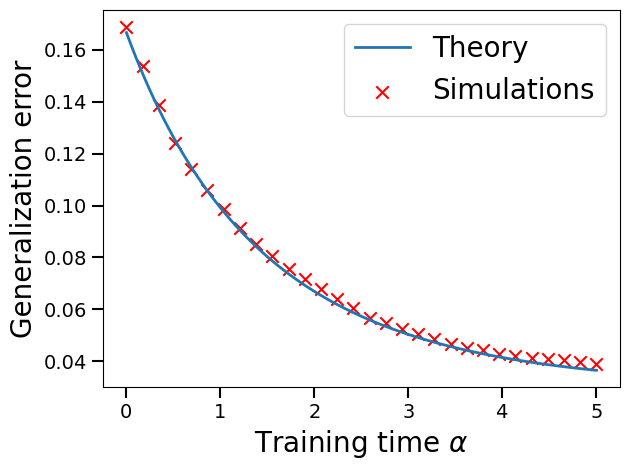

In [82]:
i=0
plt.plot(alphas,J_consts[i],label="Theory",lw=2)
plt.scatter(alphas_sims,errors_s[i],label="Simulations",marker='x',s=80,color='r') 
plt.ylabel(r"Generalization error",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
plt.legend(fontsize=20)


'\nfor l in range(1):\n    for j in [0]:\n        for k in [1]:\n            norm=[(Qmatrix_s[l][i][j,k]-Rmatrix_s[l][i][0,0]*Rmatrix_s[l][i][1,0])/np.sqrt(Qmatrix_s[l][i][0,0]*Qmatrix_s[l][i][1,1]) for i in range(len(Qs))]\n            norm_sims=[(Qsim_s[l][:, j, k][i]-Rsim_s[l][:,0,0][i]*Rsim_s[l][:,1,0][i])/np.sqrt(Qsim_s[l][:, 0, 0][i]*Qsim_s[l][:, 1, 1][i]) for i in range(len(Qsim_s[l][:, j, k]))]\n            if l==1:\n                plt.plot(alphas,norm,label=r"Theory ($r=1$)",color=\'r\',linestyle="--",linewidth=2)\n                plt.scatter(alphas_sims, norm_sims, s=30, marker="x",color=\'r\')\n            \n            if l==0:\n                plt.plot(alphas,norm,label=r"Theory ($r=0.68$)",color=\'b\',linewidth=2)\n                plt.scatter(alphas_sims, norm_sims, s=30, marker="x",color=\'b\')\n\n\n'

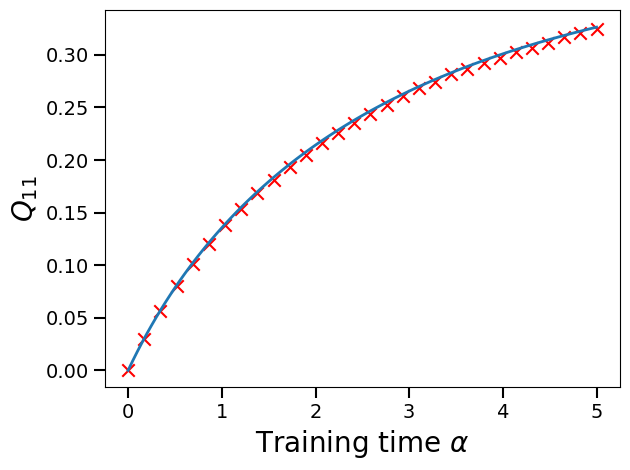

In [83]:
l=0
plt.plot(alphas,[Qmatrix_s[0][i][0,0] for i in range(len(Qmatrix_s[0]))],label="Theory",lw=2)
a=[Qsim_s[0][:, 0, 0][i] for i in range(len(Qsim_s[0][:, 0, 0]))]
alphas_sims=np.linspace(0,alphaF,len(a))
plt.scatter(alphas_sims,a,label="Simulations",marker='x',s=80,color='r') 
plt.ylabel(r"$Q_{11}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width



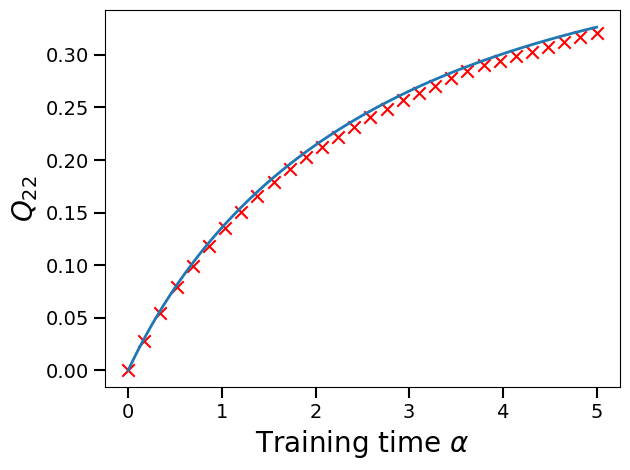

In [84]:
l=0
plt.plot(alphas,[Qmatrix_s[0][i][1,1] for i in range(len(Qmatrix_s[0]))],label="Theory",lw=2)
a=[Qsim_s[0][:, 1, 1][i] for i in range(len(Qsim_s[0][:, 0, 0]))]
alphas_sims=np.linspace(0,alphaF,len(a))
plt.scatter(alphas_sims,a,label="Simulations",marker='x',s=80,color='r') 
plt.ylabel(r"$Q_{22}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width


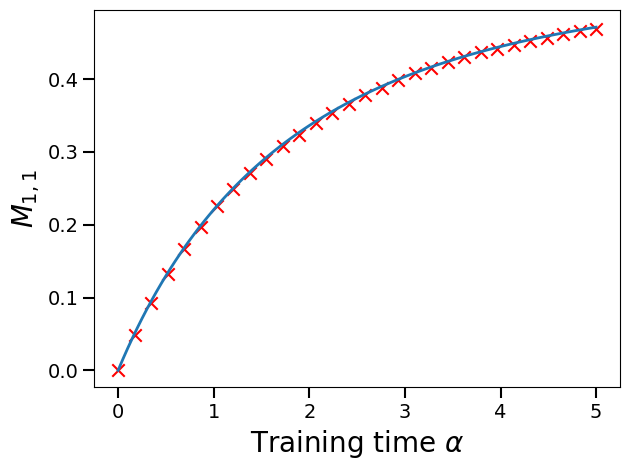

In [85]:
l=0
plt.plot(alphas,[Rmatrix_s[0][i][0,0] for i in range(len(Rmatrix_s[0]))],label="Theory",lw=2)
a=[Rsim_s[0][:, 0, 0][i] for i in range(len(Rsim_s[0][:, 0, 0]))]
alphas_sims=np.linspace(0,alphaF,len(a))
plt.scatter(alphas_sims,a,label="Simulations",marker='x',s=80,color='r') 
plt.ylabel(r"$M_{1,1}$",fontsize=20)
plt.xlabel(r"Training time $\alpha$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase label size
plt.tick_params(axis='both', which='major', length=8, width=1.5)  # Increase tick length and width
